In [18]:
import numpy as np
import matplotlib.pyplot as plt
import json
import statistics
import re
import datetime
import scipy.stats as stats

In [19]:
def read_pods_file(file_path):
    
    running_pods = []
    with open(file_path, 'r') as file:
        intervals = file.read().split("#####")
        pods_in_intervals = [interval.strip().split("\n") for interval in intervals]
        for pods in pods_in_intervals:
            action_pods = [pod for pod in pods if "float" in pod]
            running_pods.append(len(action_pods))
    
    return statistics.mean(running_pods)

In [20]:
def read_activation_file(file_path):
    activations = []

    # Open the file in read mode
    with open(file_path, 'r') as file:
        # Read each line (assuming each line contains a JSON object)
        for line in file:
            activ = json.loads(line.strip())
            activations.append(activ)
    print(activations[0]["response"]["result"])
    return activations

In [21]:
def read_timestamp_file(file_path):
    
    result = {}
    # Open the file in read mode
    with open(file_path, 'r') as file:
        for line in file:
            # Parse the JSON object
            k, v = line.strip().split(':')
            result[k.strip()] = v.strip()
    return result

    

In [22]:
def get_activation_values(activ):
    
#     print("ACTIV")
#     print(activ)
    try:
        start_time = int(activ['start'])/1000
        end_time = int(activ['end']) / 1000
        duration = int(activ['duration'])
        wait_time = int(activ['annotations'][1]['value'])
        activ_id = activ['activationId']

        # if init_annotation exists, then the function cold_started
        try:
            init_time = int(activ['annotations'][5]['value'])
            cold_start = True
        except:
            cold_start = False

        result_dict = {"cold_start": cold_start, "start_time": start_time, "end_time": end_time,
                      "duration": duration, "wait_time": wait_time}
    
        return {activ_id: result_dict}
    except:
        return None

def get_all_activation_values(activations):
    result = []
    for activ in activations:
        if get_activation_values(activ):
            result.append(get_activation_values(activ))
        else:
            continue
    return result

In [23]:
def get_experiment_container_counts(activations, timestamps):
    
    exp_start = float(timestamps['Experiment_Start'])
    exp_end = float(timestamps['Experiment_End'])
    response_times = []
    cold_containers = []
    warm_containers = []
    interval = 1
    exp_time = int(exp_end - exp_start)
    ptr = exp_start
    end = exp_start + exp_time
    c = 0
    while(ptr < end):
        activ_during_interval = []
        cold_conts_in_interval = 0
        warm_conts_in_interval = 0
        for activ in activations:
            activ_id = list(activ.keys())[0]
            start_time = activ[activ_id]['start_time']
            end_time = activ[activ_id]['end_time']
            wait_time = activ[activ_id]['wait_time'] / 1000
            inflight_start_time = start_time - wait_time
            if (ptr >= inflight_start_time) and (ptr <= end_time):
                activ_during_interval.append(activ)     
        for activ in activ_during_interval:
            activ_id = list(activ.keys())[0]
            if activ[activ_id]['cold_start']:
                cold_conts_in_interval += 1
            else:
                warm_conts_in_interval += 1
        
        cold_containers.append(cold_conts_in_interval)
        warm_containers.append(warm_conts_in_interval)
        ptr += interval
        c += 1
    avg_warm_containers = np.mean(warm_containers)
    ci_warm_containers = stats.t.ppf(0.975, len(warm_containers)-1) * np.std(warm_containers)
    avg_cold_containers = np.mean(cold_containers)
    ci_cold_containers = stats.t.ppf(0.975, len(cold_containers)-1) * np.std(cold_containers)
    
    return avg_warm_containers, avg_cold_containers, ci_warm_containers, ci_cold_containers               

In [24]:
def get_experiment_response_time(activations):
    
    resp_times = []
    
    for activ in activations:
        activ_id = list(activ.keys())[0]
        resp_time = (activ[activ_id]["duration"] + activ[activ_id]["wait_time"])/1000
        resp_times.append(resp_time)
    
    avg_resp_time = np.mean(resp_times)
    ci_resp_time = stats.t.ppf(0.975, len(resp_times)-1) * np.std(resp_times)
    
    
    return avg_resp_time, ci_resp_time
    
    

In [25]:
def get_cold_start_prob(activations):
    
    num_requests = len(activations)
    num_cold_starts = 0
    for activ in activations:
        activ_id = list(activ.keys())[0]
        if activ[activ_id]['cold_start']:
            num_cold_starts += 1
            
    return num_cold_starts/num_requests

In [26]:
def read_invoker_file(file_path):    
    messages = []
    with open(file_path, "r") as file:
        for line in file:
            messages.append(line.strip())
    
    return messages

def extract_timestamp(line):
    timestamp_pattern = r'\[(.*?)\]'
    timestamp_match = re.search(timestamp_pattern, line)
    if timestamp_match:
        return timestamp_match.group(1)
    else:
        return None

def timestamp_to_unix(timestamp_str):
    timestamp = datetime.datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    unix_timestamp_milliseconds = float(timestamp.timestamp())
    return unix_timestamp_milliseconds

def extract_tid(line):
    tid_pattern = r'\[#(.*?)\]'
    tid_match = re.search(tid_pattern, line)
    if tid_match:
        return tid_match.group(1)
    else:
        return None

                                      
def read_invoker_files(action_name, keep_alives):
    results = {}
    for ka in keep_alives:
        invoker_file_path = action_name + "_" + str(ka) + "/invoker.log"
        invocation_logs = read_invoker_file(invoker_file_path)
        results[ka] = invocation_logs
    
    return results

def get_unique_containers(invocation_logs, action_name):
    
    pattern = r'ContainerId\((.*?)\)'
    unique_containers = set()
    for log in invocation_logs:
        match = re.search(pattern, log)
        if match:
            container_id = match.group(1)
            unique_containers.add(container_id)
        else:
             continue
    action_containers = list(unique_containers)
    action_containers = [cont for cont in action_containers if action_name in cont]
    return action_containers


def get_container_lifetimes(action_containers, invocation_logs):
    
    result = {}
    start_pattern = "invoker_kubeapi.create_start"
    delete_pattern = "invoker_kubeapi.delete_start"
    for cont in action_containers:
        container_logs = []
        result[cont] = {}
        for log in invocation_logs:
            if cont in log:
                container_logs.append(log)
        
        for log in container_logs:
            if start_pattern in log:
                result[cont]["start"] = timestamp_to_unix(extract_timestamp(log))
            elif delete_pattern in log:
                result[cont]["delete"] = timestamp_to_unix(extract_timestamp(log))
        #only start, delete pattern not found
        if len(result[cont].values()) == 1:    
            result[cont]["delete"] = float('inf')
    return result

def get_active_containers(activations, container_lifetimes, invocation_logs, experiment_duration):
    
    first_activ_id = list(activations[0].keys())[0]
    start_pattern = "activationId: " + first_activ_id
    start_timestamp = 0
    for log in invocation_logs:
        if start_pattern in log:
            start_timestamp = timestamp_to_unix(extract_timestamp(log))
    ptr = start_timestamp
    end_timestamp = start_timestamp + experiment_duration
    interval = 2
    active_containers = []
    while(ptr < end_timestamp):
        count = 0
        for cont, lifetime in container_lifetimes.items():
            if lifetime['start'] < ptr and lifetime['delete'] > ptr:
                count += 1
        active_containers.append(count)
        ptr += interval
    
    avg_active_containers = np.mean(active_containers)
    ci_active_containers = stats.t.ppf(0.975, len(active_containers)-1) * np.std(active_containers)
    
    return avg_active_containers, ci_active_containers

def get_active_containers_from_invocation_logs(activations, invocation_logs, timestamps, action_name):
    
    action_containers = get_unique_containers(invocation_logs, action_name)
    container_lifetimes = get_container_lifetimes(action_containers, invocation_logs)
    experiment_duration = int(float(timestamps["Experiment_End"]) - float(timestamps["Experiment_Start"]))
    
    return get_active_containers(activations, container_lifetimes, invocation_logs, experiment_duration)

def get_container_logs(action_containers, invocation_logs):
    
    all_container_logs = {}
    for cont in action_containers:
        container_logs = []
        for log in invocation_logs:
            if cont in log:
                container_logs.append(log)
        all_container_logs[cont] = container_logs
    return all_container_logs

def get_actual_keep_alives(all_container_logs, invocation_log):

    delete_pattern = 'invoker_kubeapi.delete_start'
    activation_finish_pattern = 'invoker_activationRun_finish'
    keep_alive_times = []
    for cont, logs in all_container_logs.items():
        if delete_pattern in logs[-1]:
            #print(logs[-1])
            delete_timestamp = timestamp_to_unix(extract_timestamp(logs[-1]))
            tid_last_func = extract_tid(logs[-2])
            last_func_logs = [log for log in invocation_log if tid_last_func in log]
            activ_finish_log = [log for log in last_func_logs if activation_finish_pattern in log]
            idle_start_timestamp = timestamp_to_unix(extract_timestamp(activ_finish_log[0])) 
            keep_alive_times.append(delete_timestamp - idle_start_timestamp)
        else:
            continue
    return statistics.mean(keep_alive_times), statistics.stdev(keep_alive_times) 
    
    
            

In [27]:
## Parse experiment files
def parse_files(action_name, keep_alives):
    results = {}
    for ka in keep_alives:
        ka_in_ow = ka
        dir_name = "container_float/"
        activation_file_path = dir_name + action_name + "_" + str(ka_in_ow) + "/activation.log"
        timestamp_file_path = dir_name + action_name + "_" + str(ka_in_ow) + "/timestamp.log"
        pods_file_path = dir_name + action_name + "_" + str(ka_in_ow) + "/pods.log"
        invoker_file_path = dir_name + action_name + "_" + str(ka_in_ow) + "/invoker.log"
        activations = read_activation_file(activation_file_path)
        timestamps = read_timestamp_file(timestamp_file_path)
        #running_containers = read_pods_file(pods_file_path)
        invocation_logs = read_invoker_file(invoker_file_path)
        #results[ka] = activations, timestamps, running_containers
        results[ka] = activations, timestamps, invocation_logs
    return results
        
        
        
        

In [28]:
def get_distributions(results, action_name):
    
#     warm_containers = {}
#     cold_containers = {}
#     idle_containers = {}
#     response_times = {}
#     active_containers = {}
#     cold_start_probs = {}
#     ci_response_times = {}
#     ci_warm_containers = {}
#     ci_cold_containers = {}
#     ci_active_containers = {}
#     #avg_active_containers = {}
#     #running_containers = {}
        
#     for ka in results:
#         activations = get_all_activation_values(results[ka][0])
#         timestamps = results[ka][1]
#         invocation_logs = results[ka][2]
#         avg_warm_containers, avg_cold_containers, ci_warm_container, ci_cold_container = get_experiment_container_counts(activations, timestamps)
#         avg_response_time, ci_response_time = get_experiment_response_time(activations)
#         #active_containers[ka] = results[ka][2]
#         avg_active_containers, ci_active_container = get_active_containers_from_invocation_logs(activations, invocation_logs, timestamps, action_name)
#         warm_containers[ka] = avg_warm_containers
#         cold_containers[ka] = avg_cold_containers
#         active_containers[ka] = avg_active_containers
#         idle_containers[ka] = active_containers[ka] - avg_warm_containers - avg_cold_containers
#         response_times[ka] = avg_response_time
#         cold_start_probs[ka] = get_cold_start_prob(activations)
#         ci_response_times[ka] = ci_response_time
#         ci_warm_containers[ka] = ci_warm_container
#         ci_cold_containers[ka] = ci_cold_container
#         ci_active_containers[ka] = ci_active_container
        
#     return (warm_containers, cold_containers, active_containers, idle_containers, response_times, 
#             cold_start_probs, ci_response_times, ci_warm_containers, ci_cold_containers, ci_active_containers)
    
    exp_results = {}
    warm_containers = {}
    cold_containers = {}
    idle_containers = {}
    response_times = {}
    active_containers = {}
    cold_start_probs = {}
    ci_response_times = {}
    ci_warm_containers = {}
    ci_cold_containers = {}
    ci_active_containers = {}
    metrics = ["running_warm", "running_cold", "running_total", "idle", "total_containers", "response_time", "cold_start_probs"]
    for metric in metrics:
        exp_results[metric] = {}
            
    for ka in results:
        activations = get_all_activation_values(results[ka][0])
        timestamps = results[ka][1]
        invocation_logs = results[ka][2]
        avg_warm_containers, avg_cold_containers, ci_warm_container, ci_cold_container = get_experiment_container_counts(activations, timestamps)
        avg_response_time, ci_response_time = get_experiment_response_time(activations)
        #active_containers[ka] = results[ka][2]
        avg_active_containers, ci_active_container = get_active_containers_from_invocation_logs(activations, invocation_logs, timestamps, action_name)
        exp_results['running_warm'][ka] = avg_warm_containers
        exp_results['running_cold'][ka] = avg_cold_containers
        exp_results['running_total'][ka] = avg_warm_containers + avg_cold_containers
        exp_results['total_containers'][ka] = avg_active_containers
        exp_results['idle'][ka] = avg_active_containers - avg_warm_containers - avg_cold_containers
        exp_results['response_time'][ka] = avg_response_time
        exp_results['cold_start_probs'][ka] = get_cold_start_prob(activations)
        
    return exp_results
    #return warm_containers, cold_containers, running_containers, idle_containers, response_times

In [29]:
arrival_rates = [0.5, 1, 2, 4, 6, 8, 10, 12, 14, 16]
#keep_alives = list(map(lambda ka: ka + 2, keep_alives))
#keep_alives = [5, 30]
action_name = "float"
results = parse_files(action_name, arrival_rates)

In [30]:
exp_warm_containers, exp_cold_containers, exp_running_containers, exp_idle_containers, exp_response_times, exp_cold_start_probs, ci_response_times, ci_warm_containers, ci_cold_containers, ci_active_containers = get_distributions(results, action_name)

In [31]:
exp_response_times

{0.5: 1.6820199999999998,
 1: 1.6655933333333333,
 2: 1.6907,
 4: 1.7009454166666667,
 6: 1.7818605555555556,
 8: 1.9380570833333335,
 10: 2.4928635,
 12: 7.422138170697804,
 14: 8.274503810431055,
 16: 8.270968404588112}

In [32]:
#Container FaaS Model
from scipy.stats import expon
import numpy as np
from math import factorial, inf, exp


def ErlangB(Rho, m):
    """ErlangB calculates the blocking probability for a M/G/m/m loss system.
    The probability returned is in range [0-1].
    It is easy to prove the correctness of the value.

    Source1: https://en.wikipedia.org/wiki/Erlang_%28unit%29#Erlang_B_formula

    Source2: https://stackoverflow.com/questions/23528145/how-to-wtite-erlang-b-and-erlang-c-formulas-in-python

    :param Rho: Rho = lambda/mu
    :type Rho: double
    :param m: The number of servers.
    :type m: int
    :return: The blocking probability for incoming requests.
    :rtype: double
    """
    InvB = 1.0
    for j in range(1, m+1):
        InvB = 1.0 + InvB * (j/Rho)
    return (1.0 / InvB)


def print_props(props):
    print("\nProperties:")
    print("------------------")
    for k in props.keys():
        print(f"{k}: {props[k]:4.6f}")
    print("------------------\n")


def get_sls_warm_count_dist(arrival_rate, warm_service_time, cold_service_time, idle_time_before_kill, maximum_concurrency=1000, faster_solution=True):
    warm_service_rate = 1 / warm_service_time
    cold_service_rate = 1 / cold_service_time
    rho = arrival_rate / warm_service_rate

    server_max = maximum_concurrency
    if faster_solution:
        server_max = min(30, maximum_concurrency)
    server_count = 0

    pblock_old = 1
    kill_rate = 0

    server_counts = [0]
    block_rates = [arrival_rate]
    kill_rates = [0.0]
    cold_probs = [1]
    running_counts = [arrival_rate * 1 * cold_service_time]
    running_warm_counts = [0]
    running_cold_counts = [running_counts[0]]
    resp_times = [cold_service_time]


    while server_count < server_max:
        server_count += 1

        # The blocking probability, the blocked requests are cold starts.
        prob_block = ErlangB(rho, server_count)
        block_rate = prob_block * arrival_rate

        # The difference between blocked requests in m-1 and m is the requests
        # served on the m'th servers.
        prob_mth_server = pblock_old - prob_block
        pblock_old = prob_block

        # prob of no request in the next idle_time_before_kill for each request
        prob_kill_mth = 1 - \
            expon.cdf(idle_time_before_kill, scale=1 /
                      (arrival_rate * prob_mth_server))
        if prob_kill_mth > 0:
            # expected number of requests before the last one
            exp_request_before_kill = 1 / prob_kill_mth

            L = arrival_rate * prob_mth_server
            T = idle_time_before_kill + warm_service_time
            # average time between requests, when those requests wouldn't
            # be so far apart that results in killing the container.
#             avg_inter_arrival = (-1 * T * exp(-1 * L * T)) + \
#                 (1 - exp(-1 * L * T)) / L
            
            avg_inter_arrival = 1/L

            # Time it takes for a container to be killed after being created.
            inter_kill_time = idle_time_before_kill + \
                (exp_request_before_kill - 1) * avg_inter_arrival
            kill_rate += 1 / inter_kill_time
        else:
            kill_rate += 0

        # Average number of warm containers serving the requests
        running_count_warm = arrival_rate * \
            (1 - prob_block) * warm_service_time
        running_count_cold = arrival_rate * prob_block * cold_service_time
        running_count = running_count_warm + running_count_cold

        # Average Response Time
        resp_time = (prob_block * cold_service_time) + \
            ((1 - prob_block) * warm_service_time)

        # If we reached maximum concurrency, we don't have cold starts any more!
        if server_count == maximum_concurrency:
            resp_time = warm_service_time
            running_count_cold = 0
            running_count = running_count_warm

        # Record properties for each state in CTMC
        server_counts.append(server_count)
        block_rates.append(block_rate)
        kill_rates.append(kill_rate)
        cold_probs.append(prob_block)
        running_counts.append(running_count)
        resp_times.append(resp_time)
        running_warm_counts.append(running_count_warm)
        running_cold_counts.append(running_count_cold)

        if faster_solution:
            if block_rate > kill_rate:
                server_max = min(server_count + 30, maximum_concurrency)

    server_counts = np.array(server_counts)
    block_rates = np.array(block_rates)
    kill_rates = np.array(kill_rates)
    cold_probs = np.array(cold_probs)
    running_counts = np.array(running_counts)
    resp_times = np.array(resp_times)
    running_warm_counts = np.array(running_warm_counts)
    running_cold_counts = np.array(running_cold_counts)

    states_counts = len(server_counts)
    Q = np.zeros((states_counts, states_counts))
    for i in range(states_counts):
        out_rate = 0
        if i > 0:
            Q[i, i-1] = kill_rates[i]
            out_rate += kill_rates[i]
        if i < states_counts-1:
            Q[i, i+1] = (block_rates[i] * cold_service_rate) / (block_rates[i] + cold_service_rate)
            out_rate += (block_rates[i] * cold_service_rate) / (block_rates[i] + cold_service_rate)
        Q[i, i] = 0 - out_rate

    Q[:, 0] = 1
    y = np.zeros((1, Q.shape[0]))
    y[0, 0] = 1

    solution = np.linalg.solve(np.array(Q.T), np.array(y.T))
    solution = solution.reshape(solution.shape[0],)
    solution[solution < 0] = 0

    # if hasn't reached maximum concurrency, we can't measure it via float (accuracy is not enough, out guess is zero)
    rejection_prob = 0
    rejection_rate = 0
    # when we reach maximum concurrency, cold starts can't happen, so they are rejections
    if server_max == maximum_concurrency:
        rejection_prob = cold_probs[-1] * solution[-1]
        cold_probs[-1] = 0
        rejection_rate = block_rates[-1] * solution[-1]
        block_rates[-1] = 0

    avg_server_count = np.dot(server_counts, solution)
    avg_running_count = np.dot(running_counts, solution)
    avg_running_warm_count = np.dot(running_warm_counts, solution)
    avg_running_cold_count = np.dot(running_cold_counts, solution)
    avg_server_count_total = avg_server_count + avg_running_cold_count # total count is average of warm + average of running cold
    avg_resp_time = np.dot(resp_times, solution)
    avg_idle_count = avg_server_count - avg_running_warm_count
    cold_prob = np.dot(cold_probs, solution)
    avg_utilization = avg_running_warm_count / avg_server_count

    return {
        "avg_server_count": avg_server_count,
        "avg_server_count_total": avg_server_count_total,
        "avg_running_count": avg_running_count,
        "avg_running_warm_count": avg_running_warm_count,
        "avg_running_cold_count": avg_running_cold_count,
        "avg_idle_count": avg_idle_count,
        "cold_prob": cold_prob,
        "avg_utilization": avg_utilization,
        "avg_resp_time": avg_resp_time,
        "rejection_prob": rejection_prob,
        "rejection_rate": rejection_rate,
    }

In [36]:
def gen_model_dists(arrival_rates, warm_service_time, cold_service_time, keep_alive):
    
    model_results = {}
    for rate in arrival_rates:
        model_results[rate] = get_sls_warm_count_dist(rate, warm_service_time, cold_service_time, keep_alive)
    return model_results

In [37]:
keep_alive = 30
warm_service_time = 1.57
cold_service_time = 4.20
model_results = gen_model_dists(arrival_rates, warm_service_time, cold_service_time, keep_alive)

In [ ]:
output_json = {}
output_json["OpenWhisk"] = exp_results
output_json["Model"] = model_results

In [ ]:
output_json_string = json.dumps(output_json)
file_path = f"{action_name}_container_results.json"

# Open the file in write mode and write the JSON string
with open(file_path, 'w') as file:
    file.write(output_json_string)

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use("seaborn-whitegrid")


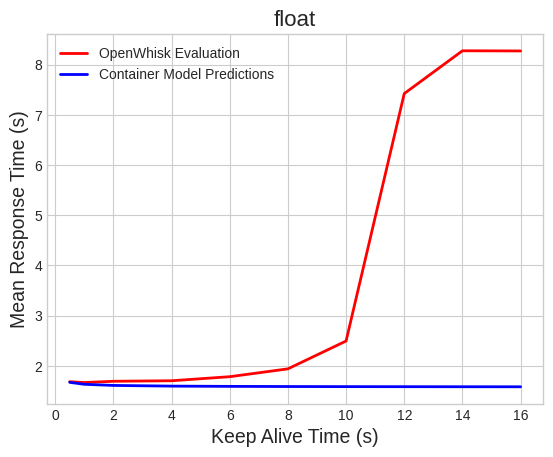

In [40]:
#plt.figure(figsize=(10, 6))
model_resp_times = [model['avg_resp_time'] for model in list(model_results.values())]
exp_resp_times = np.array(list(exp_response_times.values()))
exp_ci_resp_times = np.array(list(ci_response_times.values()))



plt.plot(arrival_rates, exp_resp_times, color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(arrival_rates, model_resp_times, color='blue', label="Container Model Predictions", linewidth=2)
plt.xlabel('Keep Alive Time (s)', fontsize=14)
plt.ylabel('Mean Response Time (s)', fontsize=14)

plt.title(action_name, fontsize=16)
#plt.ylim(0, 7)
#plt.xlim(0, 65)
plt.legend()
#plt.savefig(f"figures/{action_name}_mean_response_time.png")

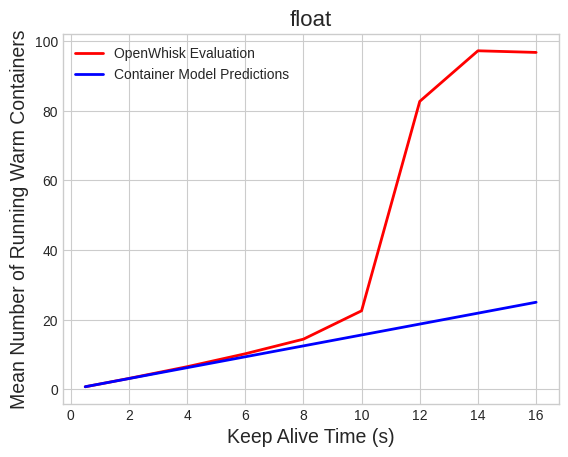

In [41]:
#plt.figure(figsize=(10, 6))

model_warm_conts = [model['avg_running_warm_count'] for model in list(model_results.values())]
exp_warm_conts = np.array(list(exp_warm_containers.values()))
exp_ci_warm_conts = np.array(list(ci_warm_containers.values()))

plt.plot(arrival_rates, exp_warm_conts, color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(arrival_rates, model_warm_conts, color='blue', label="Container Model Predictions", linewidth=2)

plt.xlabel('Keep Alive Time (s)', fontsize=14)
plt.ylabel('Mean Number of Running Warm Containers', fontsize=14)
plt.title(action_name, fontsize=16)
plt.legend()
#plt.savefig(f"figures/{action_name}_mean_warm_executors.png")

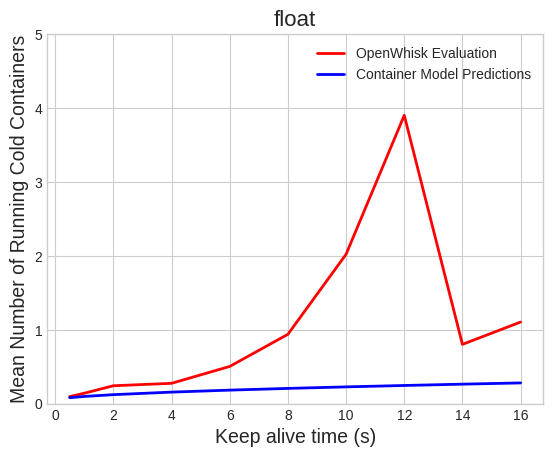

In [48]:
#plt.figure(figsize=(10, 6))

model_cold_conts = [model['avg_running_cold_count'] for model in list(model_results.values())]
exp_cold_conts = np.array(list(exp_cold_containers.values()))
exp_ci_cold_conts = np.array(list(ci_cold_containers.values()))

#plt.fill_between(keep_alives[:-4], (exp_cold_conts[:-4]-exp_ci_cold_conts[:-4]), (exp_cold_conts[:-4]+exp_ci_cold_conts[:-4]), color='r', alpha=0.1)
plt.plot(arrival_rates, exp_cold_conts, color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(arrival_rates, model_cold_conts, color='blue', label="Container Model Predictions", linewidth=2)

# Adding labels and title
plt.xlabel('Keep_alive_time (s)')
plt.ylabel('Number of Cold Containers')
plt.title('Cold Container counts against keep alive threshold')

plt.xlabel('Keep alive time (s)', fontsize=14)
plt.ylabel('Mean Number of Running Cold Containers', fontsize=14)
plt.title('float', fontsize=16)

plt.ylim(0,5)
plt.legend()
#plt.savefig(f"figures/{action_name}_mean_cold_executors.png")

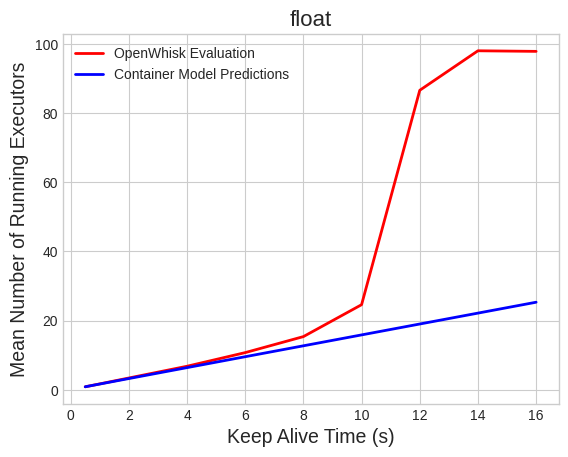

In [47]:
#plt.figure(figsize=(10, 6))

model_busy_conts = [model['avg_running_count'] for model in list(model_results.values())]

plt.plot(arrival_rates, exp_warm_conts + exp_cold_conts , color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(arrival_rates, model_busy_conts, color='blue', label="Container Model Predictions", linewidth=2)


#plt.ylim(0, 6)
# Adding labels and title
plt.xlabel('Keep Alive Time (s)', fontsize=14)
plt.ylabel('Mean Number of Running Executors', fontsize=14)
plt.title(action_name, fontsize=16)
plt.legend()
#plt.savefig(f"figures/{action_name}_mean_busy_executors.png")

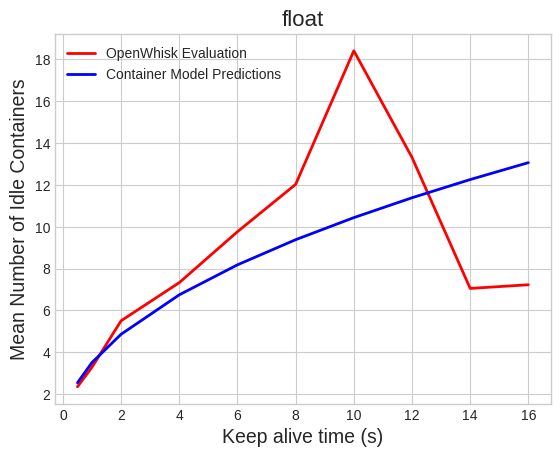

In [49]:
#plt.figure(figsize=(10, 6))

model_idle_conts = [model['avg_idle_count'] for model in list(model_results.values())]
exp_idle_conts = list(exp_idle_containers.values())
plt.plot(arrival_rates, exp_idle_conts, color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(arrival_rates, model_idle_conts, color='blue', label="Container Model Predictions", linewidth=2)

# Adding labels and title
plt.xlabel('Keep alive time (s)', fontsize=14)
plt.ylabel('Mean Number of Idle Containers', fontsize=14)
plt.title(action_name, fontsize=16)
#plt.ylim(0,6)
plt.legend()
#plt.savefig(f"figures/{action_name}_mean_idle_executors.png")

(0.0, 110.0)

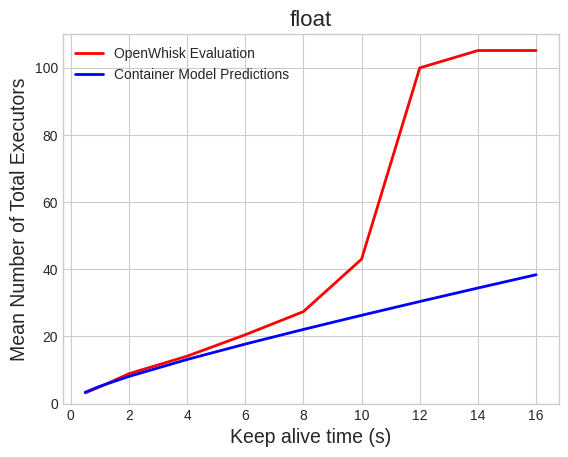

In [55]:
#plt.figure(figsize=(10, 6))

model_running_conts = [model['avg_server_count_total'] for model in list(model_results.values())]
exp_running_conts = np.array(list(exp_running_containers.values()))
exp_ci_active_conts = np.array(list(ci_active_containers.values()))

#plt.fill_between(keep_alives, (exp_running_conts-exp_ci_active_conts), (exp_running_conts+exp_ci_active_conts), color='r', alpha=0.1)


plt.plot(arrival_rates, exp_running_conts, color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(arrival_rates, model_running_conts, color='blue', label="Container Model Predictions", linewidth=2)

# Adding labels and title
plt.xlabel('Keep alive time (s)', fontsize=14)
plt.ylabel('Mean Number of Total Executors', fontsize=14)
plt.title(action_name, fontsize=16)
plt.legend()
plt.ylim(0, 110)
#plt.savefig(f"figures/{action_name}_mean_total_executors.png")

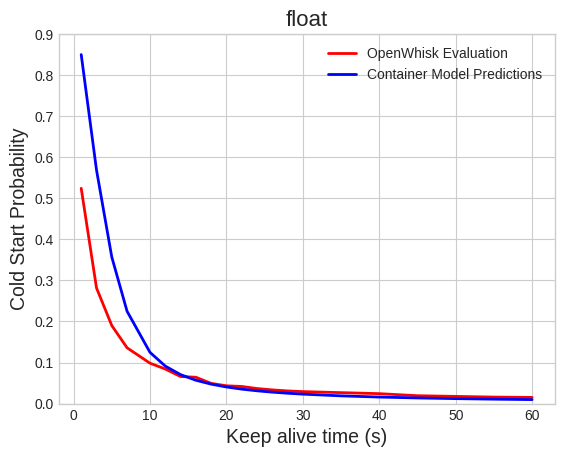

In [112]:
#plt.figure(figsize=(10, 6))

model_cold_probs = [model['cold_prob'] for model in list(model_results.values())]
exp_cold_probs = list(exp_cold_start_probs.values())
plt.plot(keep_alives[:-4], exp_cold_probs[:-4], color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(keep_alives[:-4], model_cold_probs[:-4], color='blue', label="Container Model Predictions", linewidth=2)

# Adding labels and title
plt.xlabel('Keep alive time (s)', fontsize=14)
plt.ylabel('Cold Start Probability', fontsize=14)
plt.title(action_name, fontsize=16)
plt.ylim(0, 0.9)
plt.legend()
plt.savefig(f"figures/{action_name}_cold_start_prob.png")

In [113]:
def get_warm_response_time(activations):
    
    resp_times = []
    
    for activ in activations:
        activ_id = list(activ.keys())[0]
        if activ[activ_id]["cold_start"]:
            continue
        #print(activ)
        resp_time = (activ[activ_id]["duration"] + activ[activ_id]["wait_time"])/1000
        resp_times.append(resp_time)
        
    return statistics.mean(resp_times)

def get_cold_response_time(activations):
    
    resp_times = []
    for activ in activations:
        activ_id = list(activ.keys())[0]
        if activ[activ_id]["cold_start"]:
            #print(activ)
            resp_time = (activ[activ_id]["duration"] + activ[activ_id]["wait_time"])/1000
            resp_times.append(resp_time)
    
    if resp_times:
        return statistics.mean(resp_times)
    else:
        return 0


def get_warm_cold_response_times(results):
    
    warm_response_times = {}
    cold_response_times = {}
    
    for ka in results.keys():
        activations = get_all_activation_values(results[ka][0])
        warm_response_times[ka] = get_warm_response_time(activations)
        cold_response_times[ka] = get_cold_response_time(activations)
    
    return warm_response_times, cold_response_times
    

In [114]:
def get_fire_dist(activations):
    
    fires = []
    sorted_activs = []
    for activ in activations:
        activ_id = list(activ.keys())[0]
        start_time = activ[activ_id]['start_time']
        wait_time = activ[activ_id]['wait_time'] / 1000
        inflight_start_time = start_time - wait_time
        sorted_activs.append(inflight_start_time)
        
    sorted_activs = sorted(sorted_activs)
    return sorted_activs

In [70]:
def get_num_cold_starts(activations):
    
    cold_starts = 0
    
    for activ in activations:
        activ_id = list(activ.keys())[0]
        if activ[activ_id]["cold_start"]:
            cold_starts += 1
    return cold_starts
        

In [55]:
def get_cold_start_probability(activations):
    
    num_cold_starts = get_num_cold_starts(activations)
    num_requests = len(activations)
    
    return num_cold_starts / num_requests
    

In [56]:
warm_response_times, cold_response_times = get_warm_cold_response_times(results)

In [57]:
cold_response_times

{1: 4.581325914149444,
 3: 4.347653846153846,
 5: 4.275662280701755,
 7: 4.230588957055215,
 10: 4.08778813559322,
 12: 4.217128712871287,
 14: 4.222050632911392,
 16: 4.210337662337662,
 18: 4.081271186440678,
 20: 4.077942307692307,
 22: 4.0955,
 24: 4.205409090909091,
 26: 4.22795,
 28: 4.173567567567567,
 30: 4.202971428571429,
 35: 3.9589374999999998,
 40: 4.188482758620689,
 45: 4.059391304347826,
 50: 4.139809523809523,
 55: 4.150473684210526,
 60: 3.884777777777778,
 75: 4.226875,
 90: 4.020642857142857,
 120: 4.146272727272727,
 150: 4.1465}

In [58]:
warm_response_times

{1: 1.6561593695271453,
 3: 1.6159025522041763,
 5: 1.605985596707819,
 7: 1.5935159112825459,
 10: 1.5842624768946396,
 12: 1.5839836214740672,
 14: 1.5852747546833184,
 16: 1.5781424755120215,
 18: 1.5766678352322525,
 20: 1.5664965156794426,
 22: 1.5719234782608695,
 24: 1.57780276816609,
 26: 1.5716637931034483,
 28: 1.5712828890799655,
 30: 1.5689347639484978,
 35: 1.5668724315068494,
 40: 1.5683808710503844,
 45: 1.5642480883602379,
 50: 1.566966921119593,
 55: 1.5716342082980526,
 60: 1.5632216582064298,
 75: 1.563804054054054,
 90: 1.5682091062394603,
 120: 1.556484440706476,
 150: 1.5636476510067114}

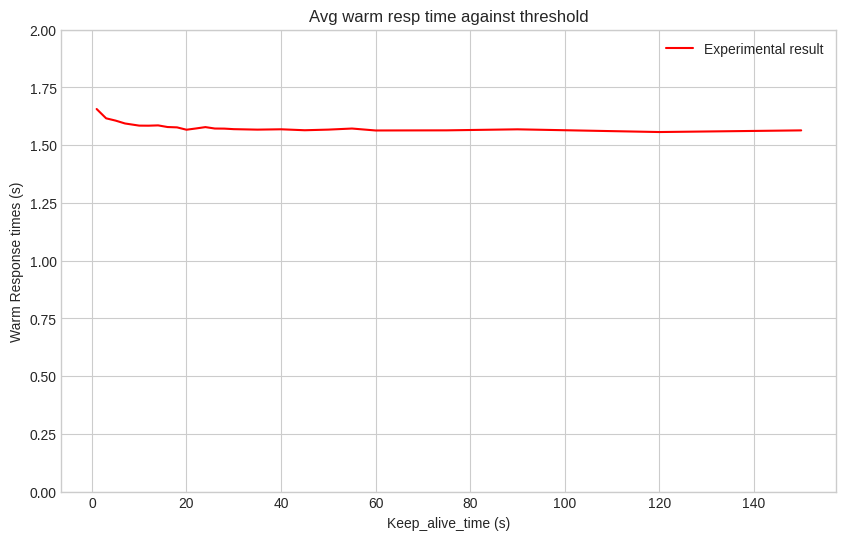

In [59]:
plt.figure(figsize=(10, 6))

exp_warm_resp_times = list(warm_response_times.values())
plt.plot(keep_alives, exp_warm_resp_times, color='red', label="Experimental result")

# Adding labels and title
plt.xlabel('Keep_alive_time (s)')
plt.ylabel('Warm Response times (s)')
plt.title('Avg warm resp time against threshold')
plt.ylim(0, 2)
plt.legend()

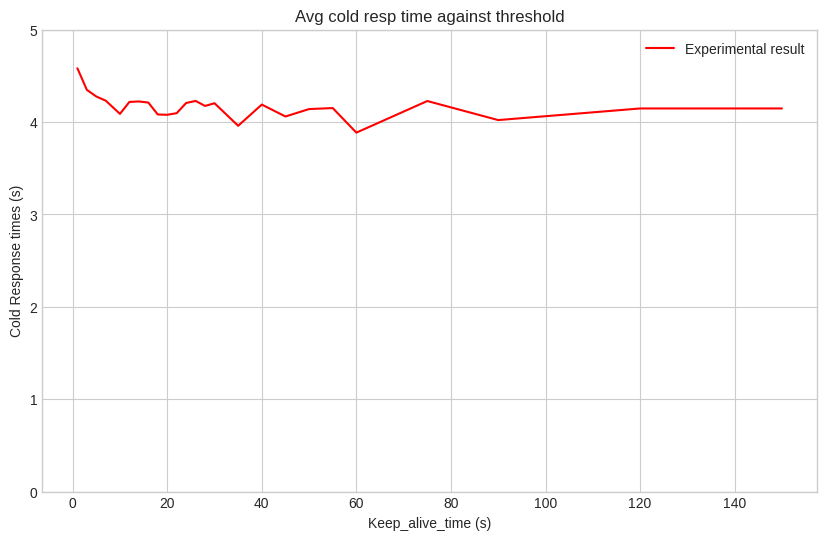

In [60]:
plt.figure(figsize=(10, 6))

exp_cold_resp_times = list(cold_response_times.values())
plt.plot(keep_alives, exp_cold_resp_times, color='red', label="Experimental result")

# Adding labels and title
plt.xlabel('Keep_alive_time (s)')
plt.ylabel('Cold Response times (s)')
plt.title('Avg cold resp time against threshold')
plt.ylim(0, 5)
plt.legend()

In [139]:
keep_alives

[3,
 5,
 7,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 75,
 90,
 120,
 150]

In [20]:
activs = read_activation_file("float_75/activation.log")
activs = get_all_activation_values(activs)
print(activs[0])

{'x': 0.8944271909996454, 'y': 1.0, 'z': 0.4472135954998034}
{'a6a0735211da46c9a0735211dad6c944': {'cold_start': False, 'start_time': 1719399089.717, 'end_time': 1719399091.32, 'duration': 1603, 'wait_time': 9}}


In [163]:
np.mean(np.diff(get_fire_dist(activs)))

1.0018857380466923

In [164]:
get_cold_response_time(activs)

4.226875

In [165]:
get_warm_response_time(activs)

1.563804054054054